In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import warnings

In [3]:
# загрузка данных

In [17]:
df = pd.read_csv('./data/taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)

In [20]:
# первичная аналитика 

In [18]:
len(df)

26496

In [19]:
display(df.describe())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [24]:
print(df.index.is_monotonic_increasing)

True


In [27]:
print('срез данных с', df.index.min())
print('           по',df.index.max())

срез данных с 2018-03-01 00:00:00
           по 2018-08-31 23:50:00


In [ ]:
# Для проведения анализа посмотрим на динамику заказов в недели и дня и дня

In [85]:
def paint_gplot(data, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 5))

    data.plot(ax=plt.gca())
    plt.title(title)
    plt.tight_layout()
    
def sum_resample(df, param):
    df = df.sort_index()
    df = df.resample(param).sum()
    return df

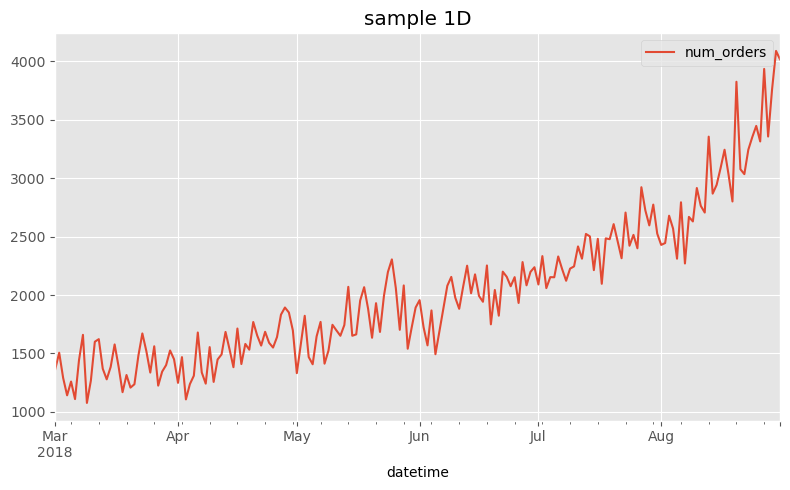

In [86]:
paint_gplot(sum_resample(df, '1D'),'sample 1D')

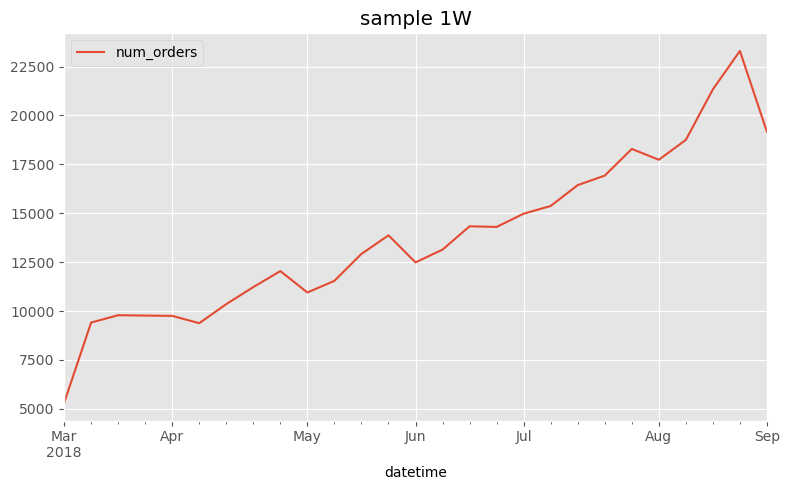

In [87]:
paint_gplot(sum_resample(df, '1W'),'sample 1W')

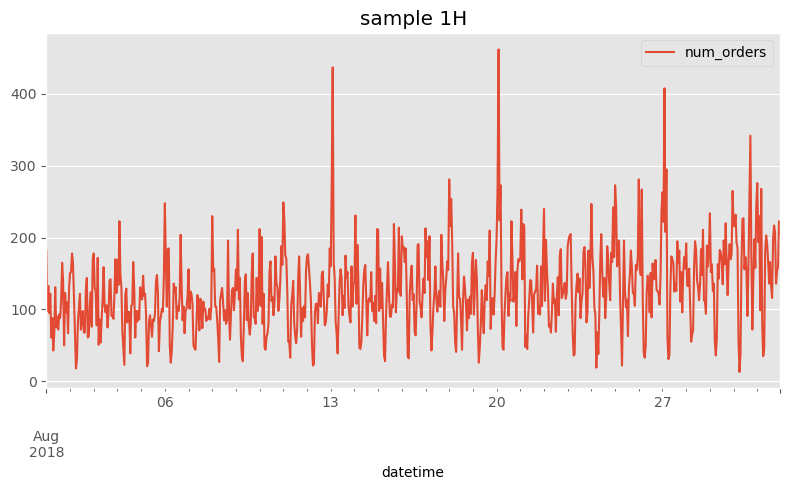

In [88]:
paint_gplot(sum_resample(df['2018-08':'2018-08'], '1H'),'sample 1H')

In [89]:
# Посмотрим на тренд, сезонность и остаток. Для анализа возьмем данные за август18 (последний месяц)

In [90]:
# Проведем ресемплирование данных по одному часу

In [91]:
df = sum_resample(df,'1H')

In [92]:
dec_taxi = df['2018-06':'2018-06']

dec_taxi['rolling_mean'] = dec_taxi['num_orders'].shift().rolling(7).mean()
dec_taxi['std'] = dec_taxi['num_orders'].rolling(7).std()
dec_taxi = dec_taxi.dropna()

C:\Users\MSI\AppData\Local\Temp\ipykernel_17052\4288830479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_taxi['rolling_mean'] = dec_taxi['num_orders'].shift().rolling(7).mean()
C:\Users\MSI\AppData\Local\Temp\ipykernel_17052\4288830479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_taxi['std'] = dec_taxi['num_orders'].rolling(7).std()


In [93]:
decomposed = seasonal_decompose(dec_taxi['num_orders'])

Text(0.5, 1.0, 'data')

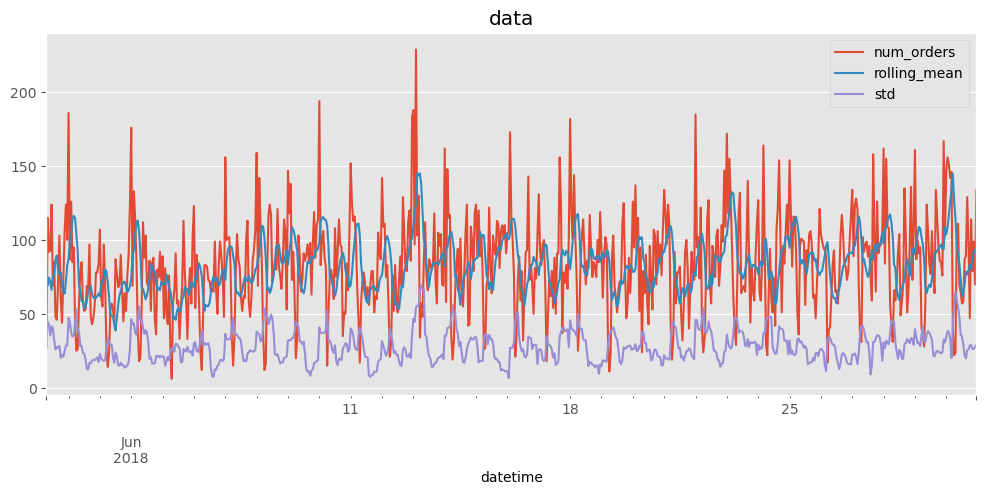

In [94]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 16))
plt.subplot(311)
dec_taxi.plot(ax=plt.gca())
plt.title('data')

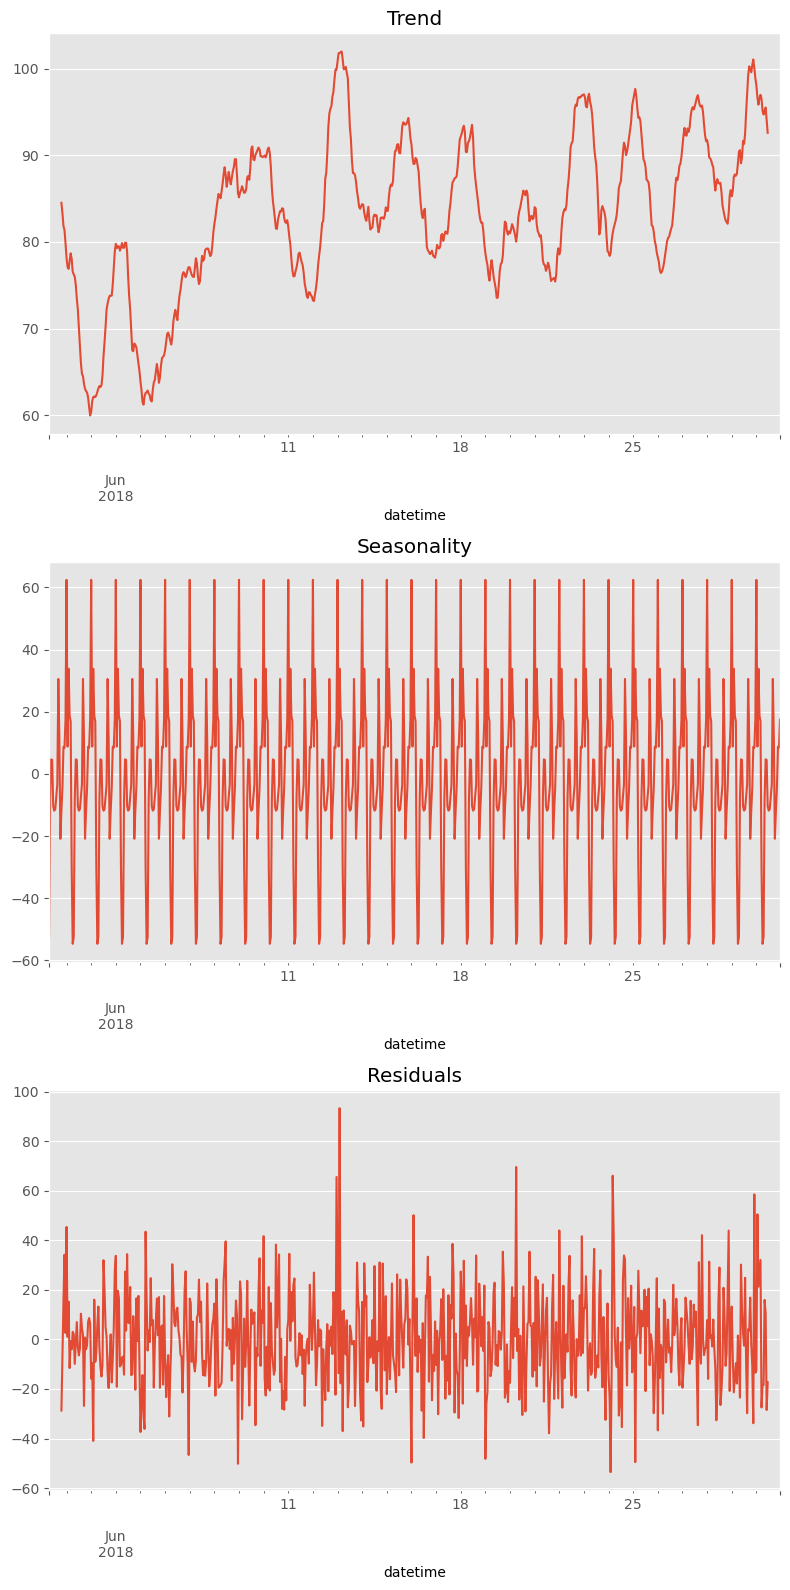

In [96]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [ ]:
# Для полной картины рассмотрим сезонность в рамках недели и дня

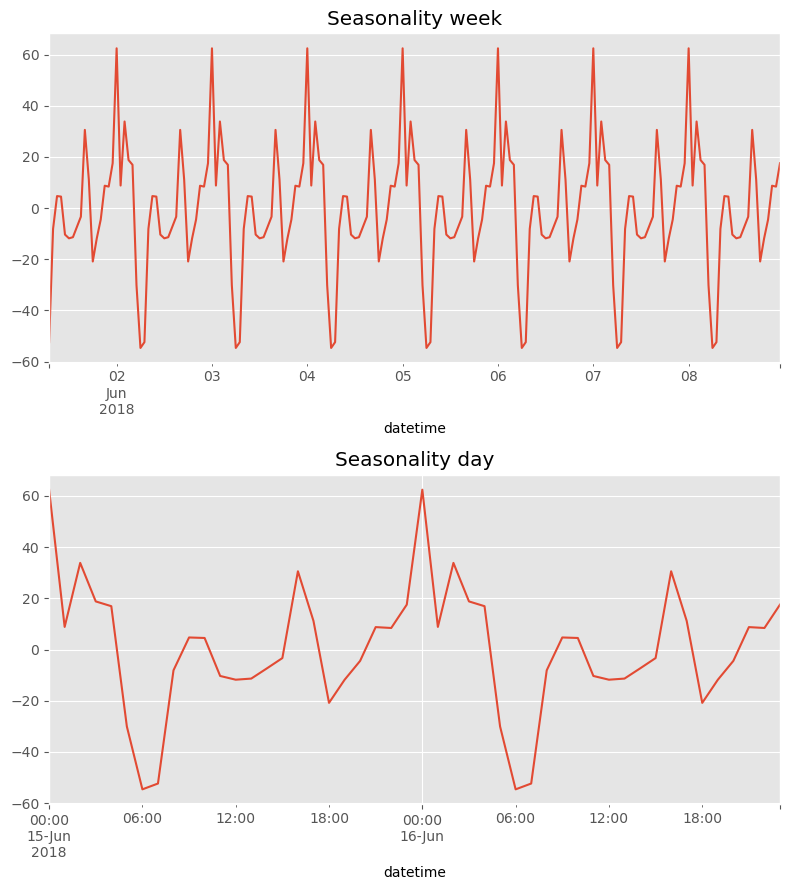

In [99]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 9))

plt.subplot(211)
decomposed.seasonal['2018-06-01':'2018-06-08'].plot(ax=plt.gca())
plt.title('Seasonality week')

plt.subplot(212)
decomposed.seasonal['2018-06-15':'2018-06-16'].plot(ax=plt.gca())
plt.title('Seasonality day')

plt.tight_layout()

Трэнд показывает линейный рост количества заказов со временем.
- Разницы между заказами в будни и выходные дни нет, видно на графике сезонности в срезе недели
- Утром значительно меньше заказов, основные пики - начало и конец рабочего дня и рост в ночное время

In [101]:
# подготовка признаков

In [102]:
def make_features(data, column, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5,6])*1
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [103]:
df = make_features(df, 'num_orders', 96, 91)

C:\Users\MSI\AppData\Local\Temp\ipykernel_17052\3772064456.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


In [104]:
df.head()

,num_orders,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,0,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,0,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,0,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,0,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# а верно мы делаем? 

In [105]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [115]:
from tqdm.notebook import tqdm

In [107]:
def split_data(data, column_target):
    target = data[column_target]
    features = data.drop(column_target, axis=1)
    return features, target

In [113]:
def rmse(prediction, target): 
    return np.sqrt(((prediction - target) ** 2).mean())
    
def rmse_scor(mse):
    print('RMSE для модели на выборке:',round((mse) ** 0.5, 2))

In [116]:
best_lag = 0
best_roll_size = 0
best_rmse = 48
for lag in tqdm(range(1, 101, 5)):
    for roll_size in range(1, 101, 5):

        df = make_features(df, 'num_orders', lag, roll_size)
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        train_features, train_target = split_data(train, 'num_orders')
        test_features, test_target = split_data(test, 'num_orders')

        model_lr = LinearRegression()
        model_lr.fit(train_features, train_target)        

        predict_lr = model_lr.predict(test_features)
        rmse_lr = rmse(predict_lr, test_target)
        if rmse_lr < best_rmse :
            best_rmse = rmse_lr
            best_lag = lag
            best_roll_size = roll_size   

  0%|          | 0/20 [00:00<?, ?it/s]

In [126]:
print('best rmse      -', round(best_rmse,2))
print('best lag       -', best_lag)
print('best roll size -', best_roll_size)

best rmse      - 40.25
best lag       - 1
best roll size - 81


In [118]:
# тестирование 

In [119]:
predicts = pd.Series(model_lr.predict(test_features), index = test_target.index, name='predict')

In [120]:
df_predicts = pd.concat([test_target, predicts], axis=1)

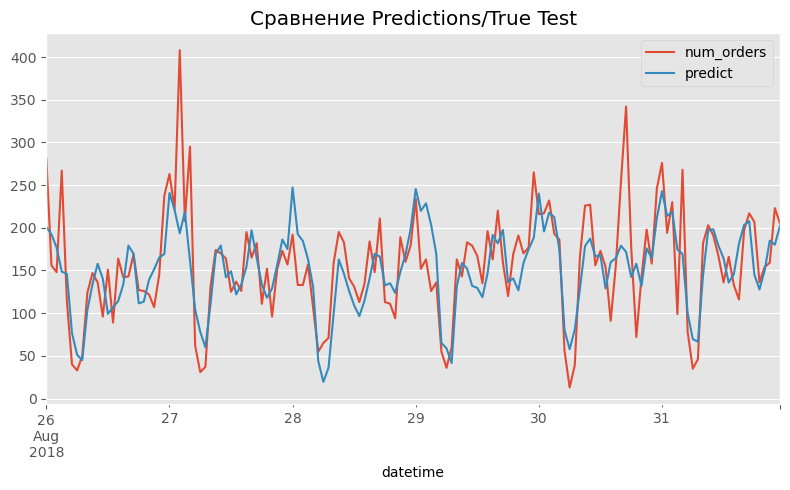

In [122]:
data = df_predicts['2018-08-26':]
paint_gplot(data,'Сравнение Predictions/True Test')